# NLP-HW2-seq2seq机器翻译-实验报告

## 模型改进

### 评估模型改进效果

从训练数据sample一部分数据作为验证集`cn-eng-test.txt`，用于评估模型效果。

1. 训练数据的train loss曲线
2. 改进模型在验证集的BELU Score

Baseline模型Train loss和BLEU Score

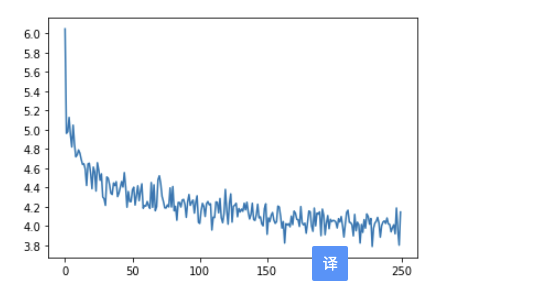

BLEU score: 0.0185

记录验证集BLEU Score

```python 

# 使用BLEU评估改进模型在验证集的表现。

import collections
from torchtext.data.metrics import bleu_score


# 读取测试数据集
with open('cn-eng-test.txt') as f:
    lines = f.read().strip().split('\n')
    
    test_pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]



test_pairs_dict = collections.defaultdict(lambda : [])

for pair in test_pairs:
    test_pairs_dict[pair[0]].append(pair[1].split(' '))


def evaluate_bleu_score():
    candicates = []
    references = []

    for i, pair in enumerate(test_pairs_dict.items(), start=1):
        candicate = evaluate(pair[0])
        if candicate[-1] == '<EOS>':
            candicate.pop(-1)
        candicates.append(candicate)
        references.append(pair[1])
    
    score = bleu_score(candicates, references)
    return score
```

### 初级改进

使用GRU替换Naive RNN

1. `seq2seq-translation-gru.ipynb` notebook，2层单向GRU
2. `seq2seq-translation-gru.ipynb` notebook，2层双向GRU

**2层单向GRU**，模型表现优于Naive RNN

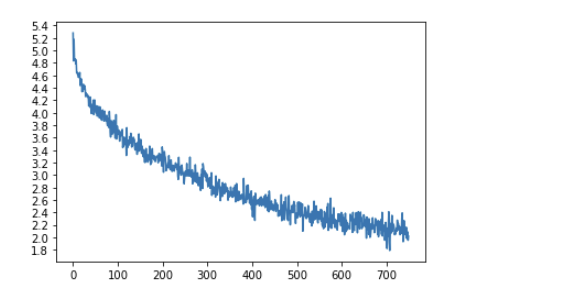

BLEU Score: 0.3201

**2层双向GRU**，模型表现优于单向GRU

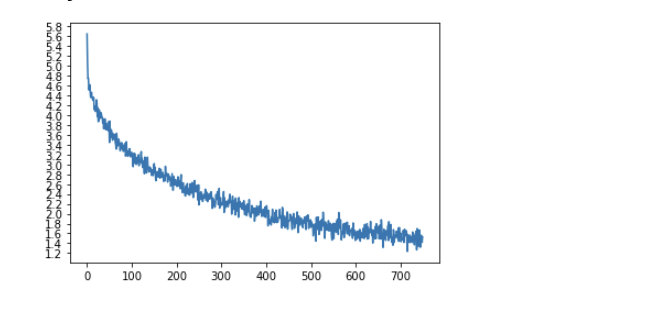

BLEu Score: 0.4427

```python

class EncoderGRU(nn.Module):
    """GRU 编码器"""

    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False):
        """
        初始化
        :param input_size, 输入词表大
        :param hidden_size, Embedding维度大小，RNN hidden大小
        :param n_layers, RNN层数
        """
        super(EncoderGRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # 用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        
    def forward(self, word_inputs, hidden):
        """
        前向传播
        :param word_inputs, 输入序列 shape(n, 1)
        :param hidden, 隐层 shape(seq_len*n_layers, batch_size, hidden_size)
        :return output(seq_len, batch, num_directions*hidden_size),
                hidden(num_layers*num_directions, hidden_size)
        """
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        num_directions = 2 if self.bidirectional else 1
        hidden = torch.zeros(self.n_layers*num_directions, 1, self.hidden_size)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

    
class DecoderGRU(nn.Module):
    """GRU 解码器"""

    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, bidirectional=False):
        super(DecoderGRU, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.bidirectional = bidirectional
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)

        # 使用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p, 
                          bidirectional=bidirectional)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden):
        # Note: we run this one step at a time        
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        rnn_output, hidden = self.rnn(word_embedded, last_hidden)

        rnn_output = rnn_output.squeeze(0)
        output = F.log_softmax(self.out(rnn_output))

        return output, hidden
```

### 进阶改进

实现attention机制，使用词替代字作为输入。参考：`seq2seq-translation-attention.ipynb`

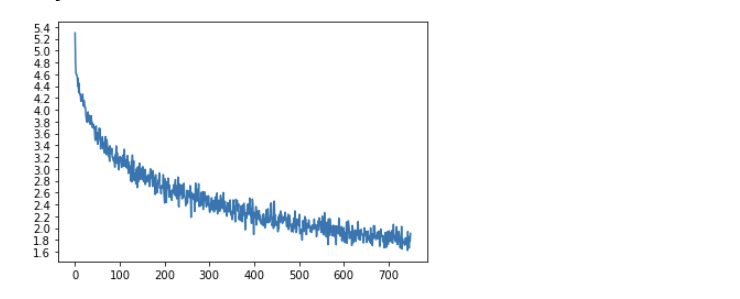

BLEU score: 0.3542，表现低于双向GRU

参考代码实现：

```python
class EncoderGRU(nn.Module):
    """GRU 编码器"""

    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False):
        """
        初始化
        :param input_size, 输入词表大
        :param hidden_size, Embedding维度大小，RNN hidden大小
        :param n_layers, RNN层数
        """
        super(EncoderGRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # 用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        """
        前向传播
        :param word_inputs, 输入序列 shape(n, 1)
        :param hidden, 隐层 shape(seq_len*n_layers, batch_size, hidden_size)
        :return output(seq_len, batch, num_directions*hidden_size),
                hidden(num_layers*num_directions, hidden_size)
        """
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        num_directions = 2 if self.bidirectional else 1
        hidden = torch.zeros(self.n_layers*num_directions, 1, self.hidden_size)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden


class Attention(nn.Module):
    """意力机制"""
    
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

        
    def forward(self, decoder_hidden, encoder_outputs):
        """
        前向传播
        :param decoder_hidden: shape(num_layers*num_directions, batch, hidden_size)
        :param encoder_outputs: shape(seq_len, batch, num_directions*hidden_size)
        :return attention_weighted_encoder_output shape(num_layers, batch, hidden_size)
        """
        attn_weights = F.softmax(torch.matmul(torch.squeeze(encoder_outputs), 
                                              torch.squeeze(decoder_hidden).view(-1, 1)))
        attn_weights = attn_weights.expand(encoder_outputs.shape[0], -1)
        attn_output = torch.sum(attn_weights * torch.squeeze(encoder_outputs), dim=0)
        return attn_output.view(1, 1, -1)

    
class DecoderGRU(nn.Module):
    """注意力机制解码器"""

    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(DecoderGRU, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.attention = Attention(hidden_size)
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)

        # 使用GRU替换RNN
        # self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time        
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        rnn_output, hidden = self.rnn(word_embedded, last_hidden)
        rnn_output = rnn_output.squeeze(0)

        # attention weighted encoder output
        attn_weighted_encoder_output = self.attention(hidden, encoder_outputs)
        attn_weighted_encoder_output = attn_weighted_encoder_output.squeeze(0)
        
        concat_output = torch.cat([rnn_output, attn_weighted_encoder_output], dim=1)
        output = F.log_softmax(self.out(concat_output))

        return output, hidden
```

### 复杂改进

实现`beamsearch`提高预测能力，参考`seq2seq-translation-bigru-beamsearch.ipynb`

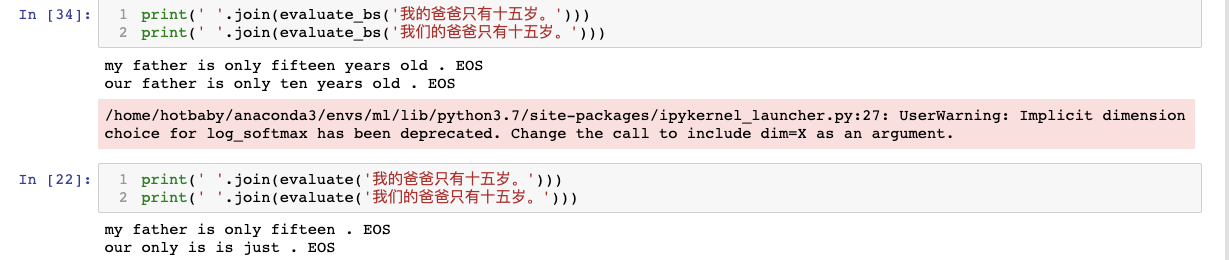

 bleu score: 0.4699，略高于没有实现beamsearch的模型。

```python
import queue

class BeamSearchNode(object):
    """Beamsearch Node"""
    
    def __init__(self, decoder_input, decoder_hidden, score, decode_words=None):
        self.decoder_input = decoder_input
        self.decoder_hidden = decoder_hidden
        self.decode_words = decode_words or []
        self.score = score
        
    def __str__(self):
        return 'BeamNode score: %s, words: %s' % (self.score, ' '.join(self.decode_words))



def evaluate_bs(sentence, max_length=MAX_LENGTH,  bs_size=2, debug=False):
    """使用beamsearch提高预测能力."""
    
    # 队列缓存BeamSeach Node
    q = queue.Queue()

    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([[SOS_token]]) # SOS
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    decoder_hidden = encoder_hidden.view(encoder.n_layers, encoder_hidden.shape[1], -1)
    
    decoder_attentions = torch.zeros(max_length, max_length)

    # First Node
    bs_node = BeamSearchNode(decoder_input, decoder_hidden, 1.0)
    q.put(bs_node)
    
    # Run through decoder
    for di in range(max_length):
        if q.empty():
            break

        # 候选集
        candidates = []
        while not q.empty():
            bs_node = q.get()
        
            if bs_node.decode_words and bs_node.decode_words[-1] == 'EOS':
                candidates.append(bs_node)
                continue

            decoder_output, decoder_hidden = decoder(bs_node.decoder_input, bs_node.decoder_hidden)

            # Choose top word from output
            # topv: top values
            # topi: top value indices
            topv, topi = decoder_output.data.topk(bs_size)
            for i in range(bs_size):
                ni = topi[0][i]
                score = abs(topv[0][i].item())   # Note: 解码器输出的是log_softmax
                decode_word = output_lang.index2word[ni.item()]
                decoder_input = torch.LongTensor([[ni]])
                if USE_CUDA:
                    decoder_input = decoder_input.cuda()

                if debug:
                    print('score: %.6f, words: %s' % (
                        bs_node.score * score, ' '.join(bs_node.decode_words + [decode_word])))

                candidates.append(BeamSearchNode(decoder_input, 
                                                 decoder_hidden,
                                                 bs_node.score*score,
                                                 bs_node.decode_words[:] + [decode_word]))

        if debug: print('\n')
        # 排序
        candidates = sorted(candidates, key=lambda x: x.score)
        for i in range(bs_size):
            q.put(candidates[i])

    return candidates[0].decode_words
```

## 测试集评测

测试集预测结果保存在`result.txt`文件中。